## Tito

Visión por Computadora 1 - TP1

1. Implementar el algoritmo de pasaje a **coordenadas cromáticas** para librarnos de las variaciones de **contraste** 
2. Implementar el algoritmo **White Patch** para librarnos de las diferencias de **color de iluminación**.

In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
%matplotlib inline

### 1. Coordenadas cromáticas
Se calculan las coordenadas cromáticas para cada pixel i,j: primero se calcula la sumatoria de la información que brindan en c/canal (sumo los 3). Luego aplico distintas variantes según corrección a realizar. El algoritmo admite:
* Jugar con luminancia para neutralizar el contraste (brillo) => por ej. vía HSV (para por gris)
* Balance de color => aplicando un factor diferencial para cada canal

En ambos casos, busco liberarme de las diferencias/alteranciones de contraste que pueden alterar percepción de imagen.

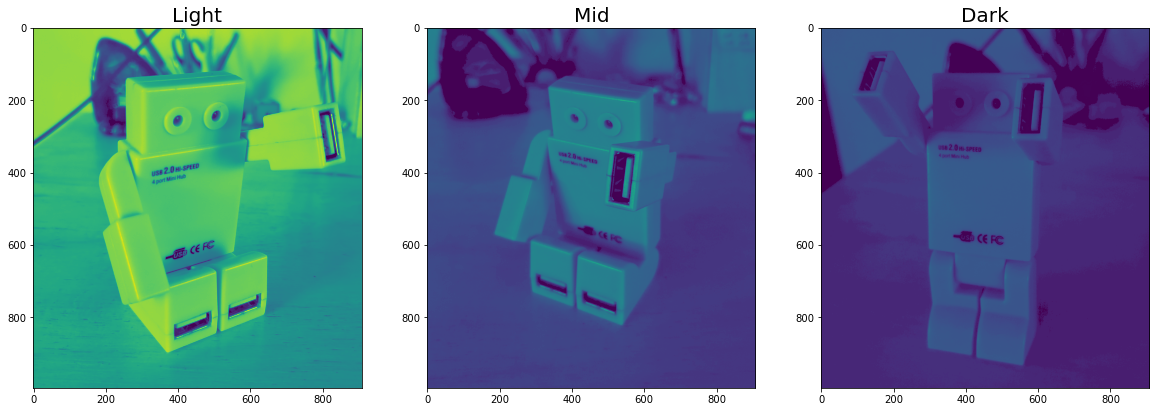

In [2]:
imgLight = cv.imread('CoordCrom_1.png',cv.IMREAD_GRAYSCALE)
imgMid = cv.imread('CoordCrom_2.png',cv.IMREAD_GRAYSCALE)
imgDark = cv.imread('CoordCrom_3.png',cv.IMREAD_GRAYSCALE)

fig = plt.figure(figsize=(20,8))

ax1 = plt.subplot(131)
ax2 = plt.subplot(132)
ax3 = plt.subplot(133)

ax1.imshow(imgLight, vmin=0, vmax=255)
ax2.imshow(imgMid, vmin=0, vmax=255)
ax3.imshow(imgDark, vmin=0, vmax=255)

ax1.set_title('Light', fontsize=20)
ax2.set_title('Mid', fontsize=20)
ax3.set_title('Dark', fontsize=20)

plt.show();

In [3]:
# coord cromáticas para lidiar con distorsiones producidas por luz incandescente
def light_balance(file_image):
    imgBGR = cv.imread(file_image)
    print('\nTamaño imagen: {} pix'.format(imgBGR.shape))
    print('Tipo de dato de cada pixel: {}'.format(imgBGR.dtype))
    # 1.split por canal
    B, G, R = cv.split(imgBGR)
        
    # 2. sumatoria de canales para c/píxel 
    sum_each_pix = np.sum(imgBGR, axis=2)
    # trunco min,max absoluto
    sum_each_pix[sum_each_pix < 1] = 1 # elimino ausencia de luz/color en denominador
    sum_each_pix[sum_each_pix > 764] = 764 # elimino blanco absoluto 
    #np.clip(img_mod, 0, 255, out=img_mod)   # Clip trunca a lo que se le diga (0 a 255)
    
    range_channel = 256 # 0-255 inclusive, so +1 = 256
    range_sum = 766 # 255*3 => 0-765 inclusive, so +1 => 766
    val_min = np.amin(sum_each_pix)
    val_max = np.amax(sum_each_pix)
    print((val_min, val_max))
    
    # 3. calculo los ratios, relación con proyección en el plano
    # genero nueva imagen con las correciones
    # es importante que los parámetros sean grandes porque sino queda casi negro (ver + ej debajo)
    # tb es clave ajustar por distintos factores para c/canal para generar rebalanceo de contrastes
    ccB = np.max(B) * 10
    ccG = np.max(G) * 10
    ccR = np.max(R) * 20
    img_cc = imgBGR.copy()
    img_cc[:, :, 0] = ccB * 1.0 * imgBGR[:, :, 0] / sum_each_pix
    img_cc[:, :, 1] = ccG * 1.0 * imgBGR[:, :, 1] / sum_each_pix
    img_cc[:, :, 2] = ccR * 1.0 * imgBGR[:, :, 2] / sum_each_pix
    #img_cc=img_cc.astype('uint8')
    print('Tipo de dato de cada pixel: {}'.format(img_cc.dtype))
   
    hists, bins = np.histogram(sum_each_pix.flatten(), 
                               range_sum, [0,range_sum]) # ravel() tb aplica
    
    fig = plt.figure(figsize=(20,5))
    ax1 = plt.subplot(131)
    ax2 = plt.subplot(132)
    ax3 = plt.subplot(133)

    ax1.imshow(imgBGR)
    ax2.plot(hists)
    for i,j,k in zip([B, G, R], ['b','g','r'], range(3)):
        ax2.axvline(np.mean(i), ls='--', c=j)
        ax2.text(np.mean(i)-70, .01+.012*k, 
                 "{}_max_value = {}".format(j, np.mean(i)), weight='bold', fontsize=10)
    ax3.imshow(img_cc)
   
    ax1.set_title('Imagen Original', fontsize=12)
    ax2.set_title('Histograma - Sumatoria de Píxeles', fontsize=12)
    ax3.set_title('CoCroma - Balance de luz (BGR)', fontsize=12)
    plt.show();
    
    #return imgBGR, img_cc, val_max


Tamaño imagen: (996, 908, 3) pix
Tipo de dato de cada pixel: uint8
(1, 764)
Tipo de dato de cada pixel: uint8


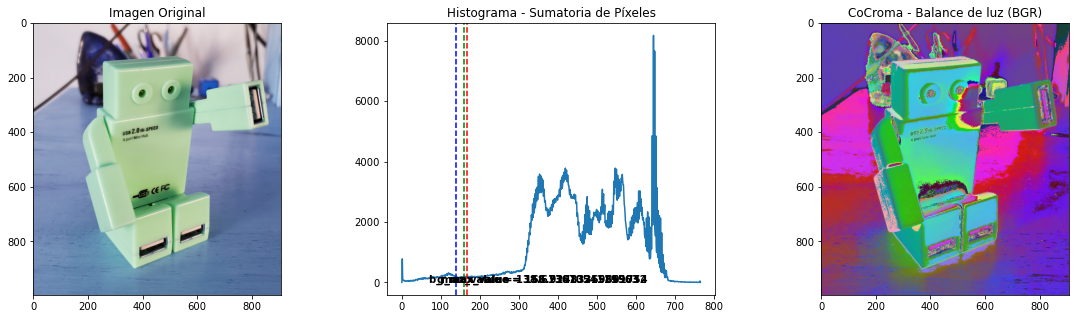


Tamaño imagen: (996, 908, 3) pix
Tipo de dato de cada pixel: uint8
(1, 549)
Tipo de dato de cada pixel: uint8


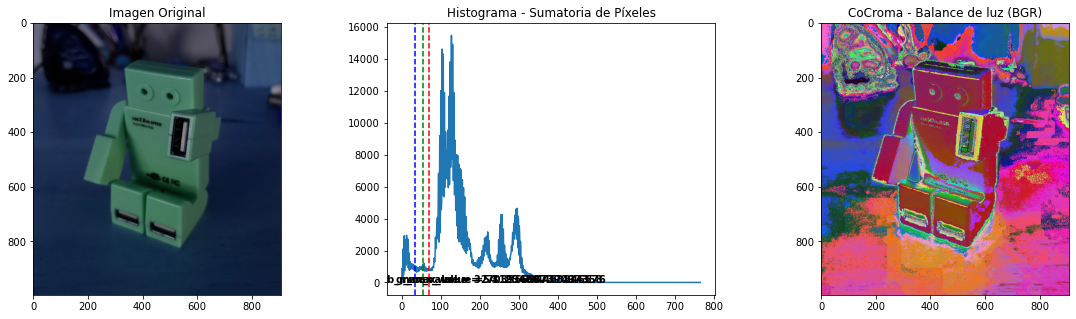


Tamaño imagen: (996, 908, 3) pix
Tipo de dato de cada pixel: uint8
(1, 386)
Tipo de dato de cada pixel: uint8


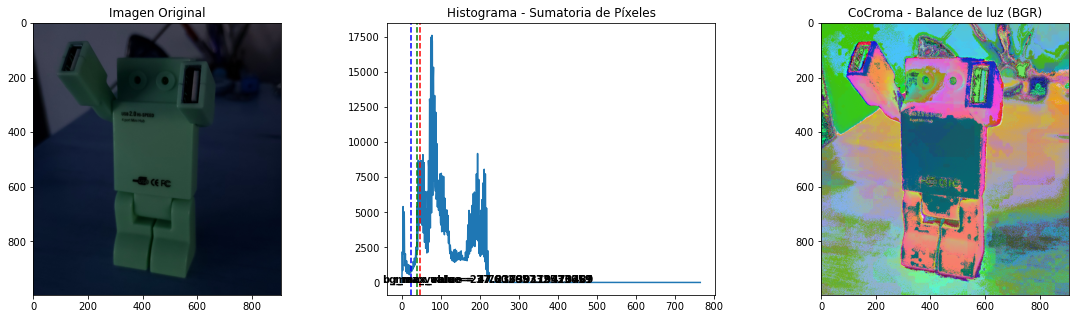

In [4]:
files = ['CoordCrom_1.png', 'CoordCrom_2.png', 'CoordCrom_3.png']
for i in files:
    light_balance(i)

### 2. Algoritmo **White Patch** 
Busco **coeficientes de corrección** para cada canal de iluminación RGB, (sR, sG, sB) en donde cada s es el cociente entre la el valor máximo de luminancia y el valor máximo de cada canal para una imagen, por ej. sR = 255/Rmax de toda la imagen. 

El propósito es neutralizar las alteraciones o diferencias de **color** de la fuente de **iluminación**.

Optar por percentil 90 aprox en caso que el máximo del canal sea 255.

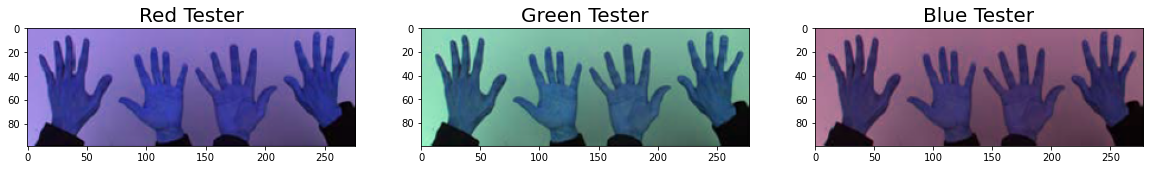

In [5]:
imgR = cv.imread('test_red.png') #,cv.IMREAD_GRAYSCALE)
imgG = cv.imread('test_green.png') #,cv.IMREAD_GRAYSCALE)
imgB = cv.imread('test_blue.png') #,cv.IMREAD_GRAYSCALE)

fig = plt.figure(figsize=(20,5))

ax1 = plt.subplot(131)
ax2 = plt.subplot(132)
ax3 = plt.subplot(133)

ax1.imshow(imgR)
ax2.imshow(imgG)
ax3.imshow(imgB)

ax1.set_title('Red Tester', fontsize=20)
ax2.set_title('Green Tester', fontsize=20)
ax3.set_title('Blue Tester', fontsize=20)

plt.show();

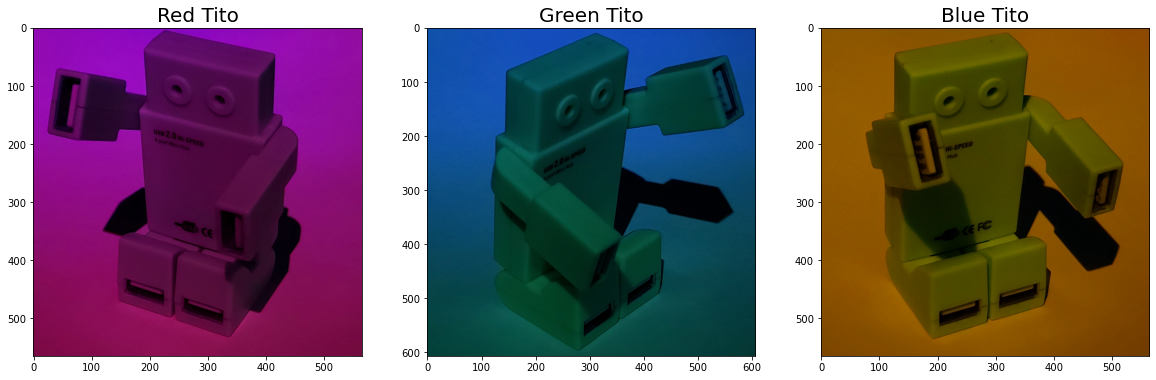

In [6]:
imgR = cv.imread('WP_R.png') #,cv.IMREAD_GRAYSCALE)
imgG = cv.imread('WP_O.png') #,cv.IMREAD_GRAYSCALE)
imgB = cv.imread('WP_B.png') #,cv.IMREAD_GRAYSCALE)

fig = plt.figure(figsize=(20,8))

ax1 = plt.subplot(131)
ax2 = plt.subplot(132)
ax3 = plt.subplot(133)

ax1.imshow(imgR)
ax2.imshow(imgG)
ax3.imshow(imgB)

ax1.set_title('Red Tito', fontsize=20)
ax2.set_title('Green Tito', fontsize=20)
ax3.set_title('Blue Tito', fontsize=20)

plt.show();

In [7]:
# White Patch Algoritmo

def wp(file_image):

    imgBGR = cv.imread(file_image)
    print('\nTamaño imagen: {} pix'.format(imgBGR.shape))
    print('Tipo de dato de cada pixel: {}'.format(imgBGR.dtype))
    
    B, G, R = cv.split(imgBGR)
    #n_B, n_G, n_R = imgBGR.shape
    #sum_ = np.zeros(b.shape)
    #sum_ = n_B.astype(np.int32) + n_G.astype(np.int32) + n_R.astype(np.int32)
    #print(sum_, n_B, n_G, n_R)
    
    Bmax = np.amax(B)
    Gmax = np.amax(G)
    Rmax = np.amax(R)
    print('Los máximos son (Rmax, Gmax, Bmax):', (Rmax, Gmax, Bmax))

    sR = float(255)/ Rmax
    sG = float(255)/ Gmax
    sB = float(255)/ Bmax
    print('Los coeficientes de corrección son (sR, sG, sB):', (round(sR,2), round(sG,2), round(sB,2)))
    
    img_wp = imgBGR.copy()
    img_wp[:, :, 0] = sB * imgBGR[:, :, 0]
    img_wp[:, :, 1] = sG * imgBGR[:, :, 1] 
    img_wp[:, :, 2] = sR * imgBGR[:, :, 2]    
       
    fig = plt.figure(figsize=(10,5))
    ax1 = plt.subplot(121)
    ax2 = plt.subplot(122)
    
    ax1.imshow(imgBGR)
    ax2.imshow(img_wp)
   
    ax1.set_title('Imagen Original', fontsize=12)
    ax2.set_title('Correción con White Patch', fontsize=12)
    plt.show();
    
    #return imgRGB, img_wp, (sR, sG, sB) 


Tamaño imagen: (565, 565, 3) pix
Tipo de dato de cada pixel: uint8
Los máximos son (Rmax, Gmax, Bmax): (208, 47, 173)
Los coeficientes de corrección son (sR, sG, sB): (1.23, 5.43, 1.47)


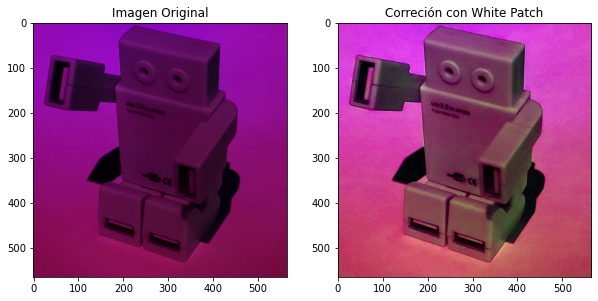


Tamaño imagen: (607, 607, 3) pix
Tipo de dato de cada pixel: uint8
Los máximos son (Rmax, Gmax, Bmax): (199, 112, 49)
Los coeficientes de corrección son (sR, sG, sB): (1.28, 2.28, 5.2)


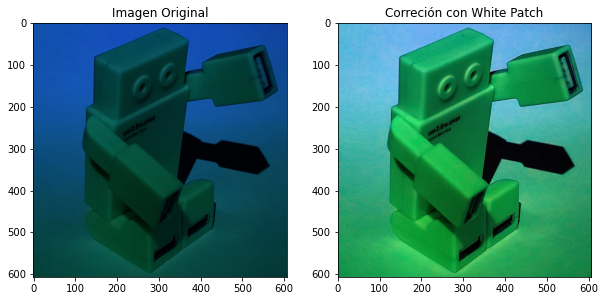


Tamaño imagen: (565, 565, 3) pix
Tipo de dato de cada pixel: uint8
Los máximos son (Rmax, Gmax, Bmax): (31, 118, 166)
Los coeficientes de corrección son (sR, sG, sB): (8.23, 2.16, 1.54)


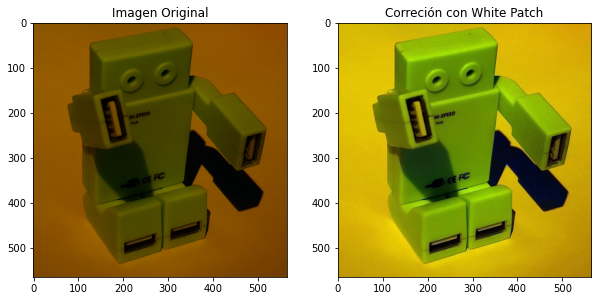

In [8]:
files = ['WP_R.png', 'WP_O.png', 'WP_B.png']

for i in files:
    wp(i)

Si bien persiste la presencia de color sobre las imágenes, los factores de corrección contribuyen a discriminar mejor por contraste. A continuación se prueba el algoritmo con las imágenes de manos, presentando una mayor uniformidad entre las imágenes resultantes tras la corrección.


Tamaño imagen: (99, 276, 3) pix
Tipo de dato de cada pixel: uint8
Los máximos son (Rmax, Gmax, Bmax): (247, 157, 175)
Los coeficientes de corrección son (sR, sG, sB): (1.03, 1.62, 1.46)


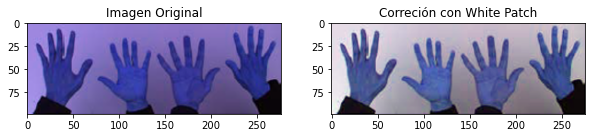


Tamaño imagen: (100, 278, 3) pix
Tipo de dato de cada pixel: uint8
Los máximos son (Rmax, Gmax, Bmax): (210, 250, 171)
Los coeficientes de corrección son (sR, sG, sB): (1.21, 1.02, 1.49)


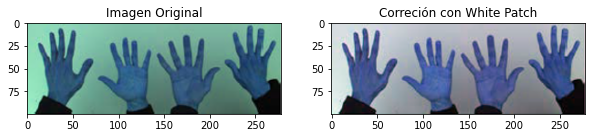


Tamaño imagen: (100, 278, 3) pix
Tipo de dato de cada pixel: uint8
Los máximos son (Rmax, Gmax, Bmax): (165, 138, 200)
Los coeficientes de corrección son (sR, sG, sB): (1.55, 1.85, 1.27)


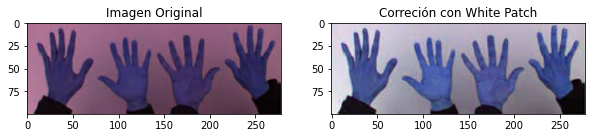

In [9]:
files = ['test_red.png', 'test_green.png', 'test_blue.png']
for i in files:
    wp(i)

### 3. Otras visualizaciones, mucho de prueba y error

In [10]:
# para ver imágenes y segmentarlas por canal
def see_img(file_image):

    imgBGR = cv.imread(file_image) #, cv.COLOR_BGR2RGB) # same as imgBGR[::-1,:,::-1]
    print('\nTamaño imagen: {} pix'.format(imgBGR.shape))
    print('Tipo de dato de cada pixel: {}'.format(imgBGR.dtype))
    
    B, G, R = cv.split(imgBGR)
    fig = plt.figure(figsize=(20,8))

    ax1 = plt.subplot(141)
    ax2 = plt.subplot(142)
    ax3 = plt.subplot(143)
    ax4 = plt.subplot(144)

    ax1.imshow(R)#, cmap='gray')
    ax2.imshow(G)#, cmap='gray')
    ax3.imshow(B)#, cmap='gray')
    ax4.imshow(imgBGR)

    ax1.set_title('Red Channel', fontsize=20)
    ax2.set_title('Green Channel', fontsize=20)
    ax3.set_title('Blue Channel', fontsize=20)
    ax4.set_title('Original BGR', fontsize=20)

    plt.show()
    
    return imgBGR, R, G, B 


Tamaño imagen: (565, 565, 3) pix
Tipo de dato de cada pixel: uint8


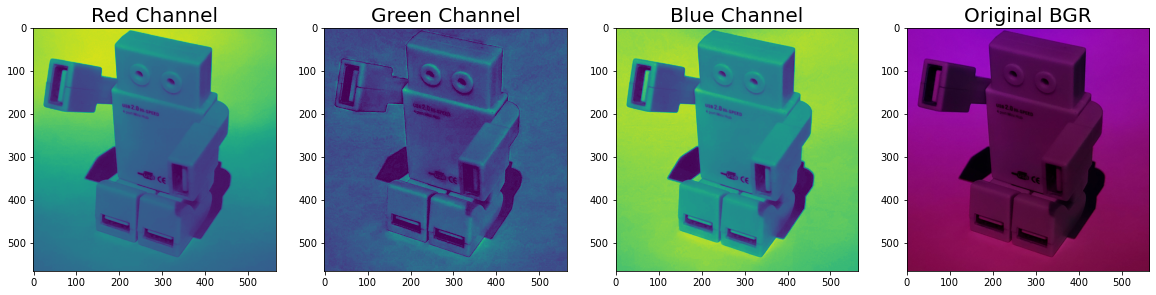


Tamaño imagen: (607, 607, 3) pix
Tipo de dato de cada pixel: uint8


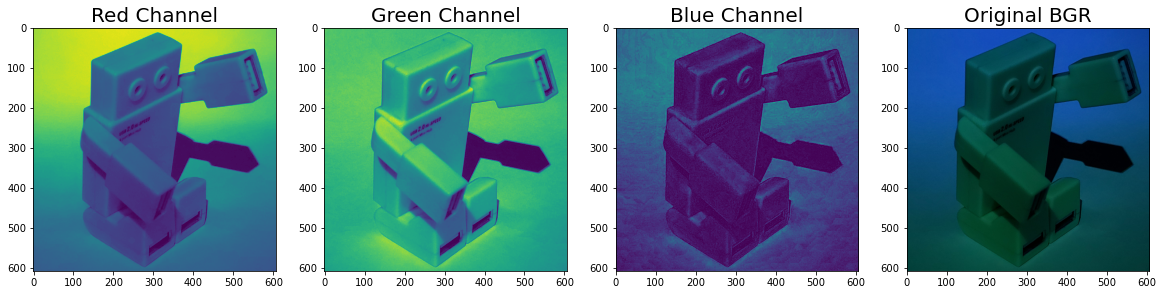


Tamaño imagen: (565, 565, 3) pix
Tipo de dato de cada pixel: uint8


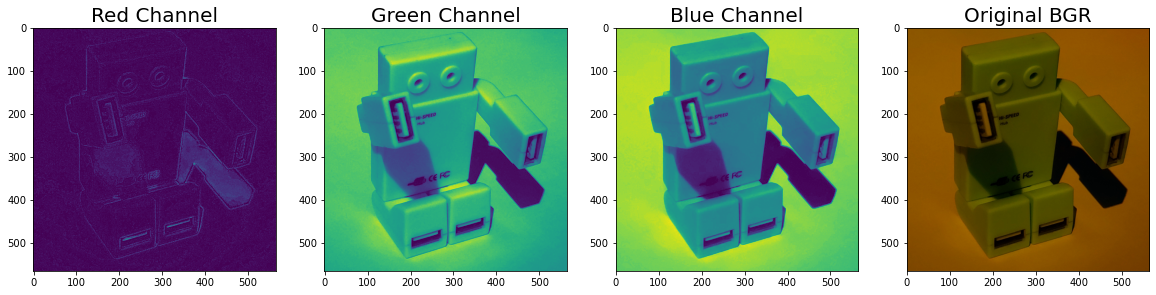

In [11]:
#rgb = ['Red', 'Green', 'Blue']
#files = ['test_red.png', 'test_green.png', 'test_blue.png']
files = ['WP_R.png', 'WP_O.png', 'WP_B.png']
#files = ['CoordCrom_1.png', 'CoordCrom_2.png', 'CoordCrom_3.png']
#for i,j in zip(files,rgb):
for i in files:
    imgBGR, R, G, B = see_img(i)

In [12]:
def chromaticity(file_image):

    imgBGR = cv.imread(file_image)
    B, G, R = cv.split(imgBGR)
    print('\nTamaño imagen: {} pix'.format(imgBGR.shape))
    print('Tipo de dato de cada pixel: {}'.format(imgBGR.dtype))

    hsv = cv.cvtColor(imgBGR, cv.COLOR_BGR2HSV)
    H, S, V = cv.split(hsv)
    
    img_sum_pix = np.sum(imgBGR, axis=2).reshape(B.shape)
    img_sum_pix[img_sum_pix < 1] = 1 # elimino el negro puro
    #img_sum_pix[img_sum_pix > 254] = 254 
    
    val_min = np.amin(img_sum_pix)
    val_max = np.amax(img_sum_pix)
    print((val_min, val_max))
    
    s = 1
    img_cc = imgBGR.copy()
    img_cc[:, :, 0] = s * imgBGR[:, :, 0] / img_sum_pix
    img_cc[:, :, 1] = s * imgBGR[:, :, 1] / img_sum_pix
    img_cc[:, :, 2] = s * imgBGR[:, :, 2] / img_sum_pix
    
    hists, bins = np.histogram(img_sum_pix.flatten(),val_max, [0,val_max]) # ravel() tb aplica
    #plt.plot(hists);

    fig = plt.figure(figsize=(20,6))
    ax1 = plt.subplot(151)
    ax2 = plt.subplot(152)
    ax3 = plt.subplot(153)
    ax4 = plt.subplot(154)
    ax5 = plt.subplot(155)
    
    ax1.imshow(img_cc)
    ax2.imshow(hsv)
    ax3.imshow(H) #, cmap='gray') # curva HUE, discrimina e/ color de objeto y el fondo
    ax4.imshow(S) #, cmap='gray') # curva SATURACIÓN, tb discrimina entre objeto y fondo (cambia foco de superficie)
    ax5.imshow(V) #, cmap='gray') # INTENSIDAD, permite discriminar entre objetos si hay contrastes
    
    #ax1.set_title('Original BGR', fontsize=12)
    #ax2.set_title('Correción con Coordenadas Cromáticas', fontsize=12)
    plt.show();
    
    idx_col = 450
    perfil_color = hsv[:,idx_col] # columna sobre la que saco perfil descriptivo de características HSV
    plt.plot(perfil_color[:,0], color='r', label='H')
    plt.plot(perfil_color[:,1], color='g', label='S')
    plt.plot(perfil_color[:,2], color='b', label='V')
    plt.xlabel('Fila')
    plt.ylabel('Intensidad')
    plt.title('Perfil sobre la columna {}'.format(idx_col))
    plt.grid()
    plt.xlim(0,480)
    plt.ylim(0,255)
    plt.legend()
    plt.show()
    
    #zeros = np.zeros(imgBGR.shape[:2],dtype='uint8')
    
    return imgBGR, img_cc


Tamaño imagen: (996, 908, 3) pix
Tipo de dato de cada pixel: uint8
(1, 765)


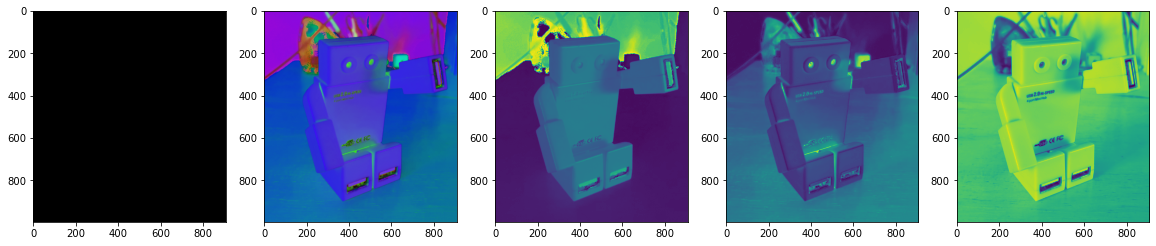

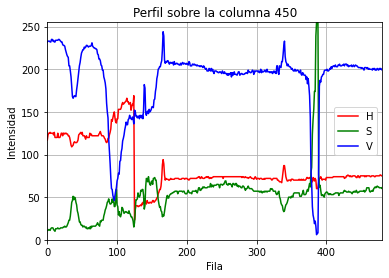


Tamaño imagen: (996, 908, 3) pix
Tipo de dato de cada pixel: uint8
(1, 549)


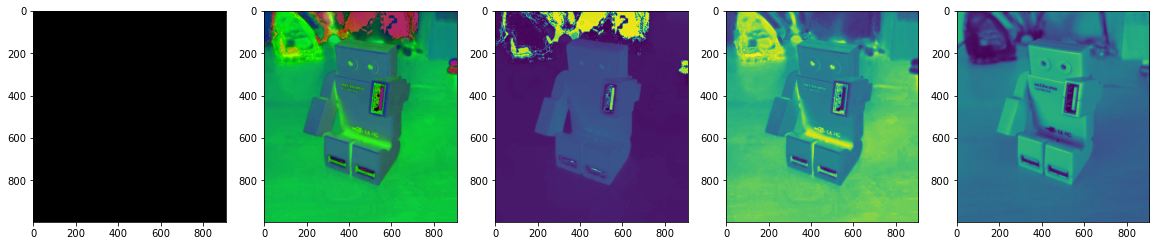

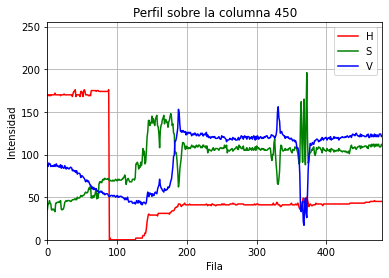


Tamaño imagen: (996, 908, 3) pix
Tipo de dato de cada pixel: uint8
(1, 386)


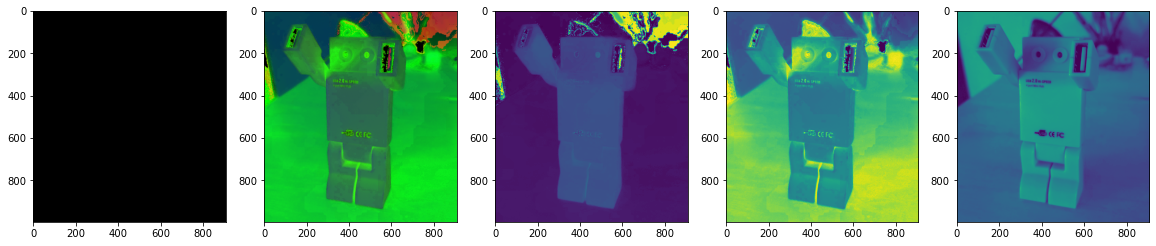

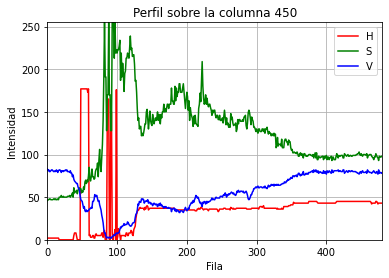

In [13]:
files = ['CoordCrom_1.png', 'CoordCrom_2.png', 'CoordCrom_3.png']
for i in files:
    imgBGR, img_cc = chromaticity(i)
    #np.seterr(divide = 'ignore')

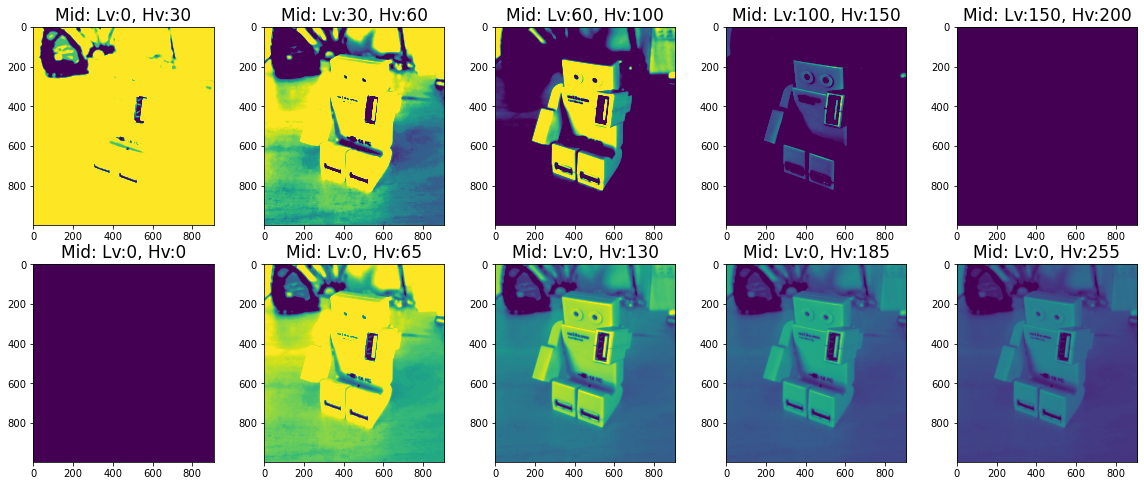

In [14]:
fig = plt.figure(figsize=(20,8))

ax1 = plt.subplot(251)
ax2 = plt.subplot(252)
ax3 = plt.subplot(253)
ax4 = plt.subplot(254)
ax5 = plt.subplot(255)
ax6 = plt.subplot(256)
ax7 = plt.subplot(257)
ax8 = plt.subplot(258)
ax9 = plt.subplot(259)
ax10 = plt.subplot(2,5,10)

ax1.imshow(imgMid, vmin=0, vmax=30)
ax2.imshow(imgMid, vmin=30, vmax=60)
ax3.imshow(imgMid, vmin=60, vmax=100)
ax4.imshow(imgMid, vmin=100, vmax=150)
ax5.imshow(imgMid, vmin=150, vmax=200)
ax6.imshow(imgMid, vmin=0, vmax=0)
ax7.imshow(imgMid, vmin=0, vmax=65)
ax8.imshow(imgMid, vmin=0, vmax=130)
ax9.imshow(imgMid, vmin=0, vmax=185)
ax10.imshow(imgMid, vmin=0, vmax=255)

ax1.set_title('Mid: Lv:0, Hv:30', fontsize=17)
ax2.set_title('Mid: Lv:30, Hv:60', fontsize=17)
ax3.set_title('Mid: Lv:60, Hv:100', fontsize=17)
ax4.set_title('Mid: Lv:100, Hv:150', fontsize=17)
ax5.set_title('Mid: Lv:150, Hv:200', fontsize=17)
ax6.set_title('Mid: Lv:0, Hv:0', fontsize=17)
ax7.set_title('Mid: Lv:0, Hv:65', fontsize=17)
ax8.set_title('Mid: Lv:0, Hv:130', fontsize=17)
ax9.set_title('Mid: Lv:0, Hv:185', fontsize=17)
ax10.set_title('Mid: Lv:0, Hv:255', fontsize=17)

plt.show();

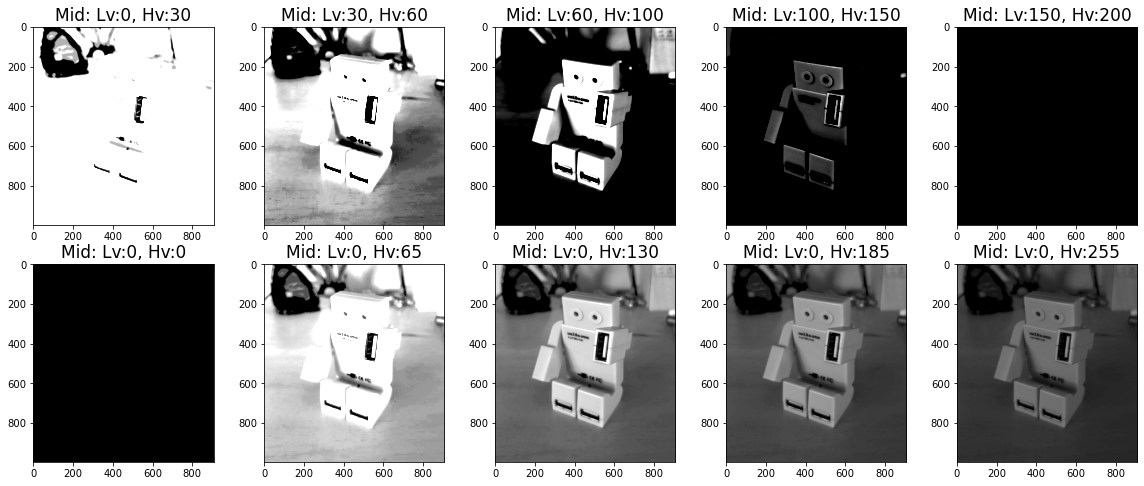

In [15]:
fig = plt.figure(figsize=(20,8))

ax1 = plt.subplot(251)
ax2 = plt.subplot(252)
ax3 = plt.subplot(253)
ax4 = plt.subplot(254)
ax5 = plt.subplot(255)
ax6 = plt.subplot(256)
ax7 = plt.subplot(257)
ax8 = plt.subplot(258)
ax9 = plt.subplot(259)
ax10 = plt.subplot(2,5,10)

ax1.imshow(imgMid, cmap='gray', vmin=0, vmax=30)
ax2.imshow(imgMid, cmap='gray',vmin=30, vmax=60)
ax3.imshow(imgMid, cmap='gray',vmin=60, vmax=100)
ax4.imshow(imgMid, cmap='gray',vmin=100, vmax=150)
ax5.imshow(imgMid, cmap='gray',vmin=150, vmax=200)
ax6.imshow(imgMid, cmap='gray',vmin=0, vmax=0)
ax7.imshow(imgMid, cmap='gray',vmin=0, vmax=65)
ax8.imshow(imgMid, cmap='gray',vmin=0, vmax=130)
ax9.imshow(imgMid, cmap='gray',vmin=0, vmax=185)
ax10.imshow(imgMid, cmap='gray',vmin=0, vmax=255)

ax1.set_title('Mid: Lv:0, Hv:30', fontsize=17)
ax2.set_title('Mid: Lv:30, Hv:60', fontsize=17)
ax3.set_title('Mid: Lv:60, Hv:100', fontsize=17)
ax4.set_title('Mid: Lv:100, Hv:150', fontsize=17)
ax5.set_title('Mid: Lv:150, Hv:200', fontsize=17)
ax6.set_title('Mid: Lv:0, Hv:0', fontsize=17)
ax7.set_title('Mid: Lv:0, Hv:65', fontsize=17)
ax8.set_title('Mid: Lv:0, Hv:130', fontsize=17)
ax9.set_title('Mid: Lv:0, Hv:185', fontsize=17)
ax10.set_title('Mid: Lv:0, Hv:255', fontsize=17)

plt.show();

In [16]:
'''hsv = cv.cvtColor(imgBGR, cv.COLOR_RGB2HSV)
zeros = np.zeros(imgBGR.shape[:2],dtype='uint8')
for (name,chan) in zip(('H','S','V'), cv.split(hsv)):
    cv.imshow(name,chan)
cv.waitKey()
cv.destroyAllWindows()'''

"hsv = cv.cvtColor(imgBGR, cv.COLOR_RGB2HSV)\nzeros = np.zeros(imgBGR.shape[:2],dtype='uint8')\nfor (name,chan) in zip(('H','S','V'), cv.split(hsv)):\n    cv.imshow(name,chan)\ncv.waitKey()\ncv.destroyAllWindows()"